In [437]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skimage.draw import disk
from einops import rearrange
plt.rcParams['figure.dpi'] = 100

In [438]:
phantom_size = 120

# 3T Gray Matter
param_GM = {
    "PD": 0.8,
    "T1": 1.56,
    "T2": 0.083,
    "T2'": 0.32,
    "D": 0.83
}
# 3T White Matter
param_WM = {
    "PD": 0.7,
    "T1": 0.83,
    "T2": 0.075,
    "T2'": 0.18,
    "D": 0.65
}
# 3T CSF
param_CSF = {
    "PD": 1,
    "T1": 4.16,
    # "T2": 1.65,
    "T2": 0.15,
    "T2'": 0.059,
    "D": 3.19
}
# 3T Fat
param_FAT = {
    "PD": 1,
    "T1": 0.37,
    "T2": 0.125,
    "T2'": 0.012,
    "D": 0.1
}

radius = 20
center = np.array([[30, 30],[30, 90],[90, 30],[90, 90]])

PD_map,T1_map,T2_map,T2_dash_map,D_map= np.zeros((phantom_size, phantom_size)),np.zeros((phantom_size, phantom_size)),np.zeros((phantom_size, phantom_size)),np.zeros((phantom_size, phantom_size)),np.zeros((phantom_size, phantom_size))

def draw_circle(image, center, radius, value):
    rr, cc = disk(center, radius)
    image[rr, cc] = value
    return image

mask_1, mask_2, mask_3, mask_4 = np.zeros((phantom_size, phantom_size)), np.zeros((phantom_size, phantom_size)), np.zeros((phantom_size, phantom_size)), np.zeros((phantom_size, phantom_size))
mask_1 = draw_circle(mask_1, center[0], radius, 1)
mask_2 = draw_circle(mask_2, center[1], radius, 1)
mask_3 = draw_circle(mask_3, center[2], radius, 1)
mask_4 = draw_circle(mask_4, center[3], radius, 1)
mask_1[mask_1 == 0] = np.nan
mask_2[mask_2 == 0] = np.nan
mask_3[mask_3 == 0] = np.nan
mask_4[mask_4 == 0] = np.nan
mask_1 = torch.tensor(mask_1[:,:,np.newaxis])
mask_2 = torch.tensor(mask_2[:,:,np.newaxis])
mask_3 = torch.tensor(mask_3[:,:,np.newaxis])
mask_4 = torch.tensor(mask_4[:,:,np.newaxis])


PD_map = draw_circle(PD_map, center[0], radius, param_GM["PD"])
PD_map = draw_circle(PD_map, center[1], radius, param_WM["PD"])
PD_map = draw_circle(PD_map, center[2], radius, param_CSF["PD"])
PD_map = draw_circle(PD_map, center[3], radius, param_FAT["PD"])

T1_map = draw_circle(T1_map, center[0], radius, param_GM["T1"])
T1_map = draw_circle(T1_map, center[1], radius, param_WM["T1"])
T1_map = draw_circle(T1_map, center[2], radius, param_CSF["T1"])
T1_map = draw_circle(T1_map, center[3], radius, param_FAT["T1"])

T2_map = draw_circle(T2_map, center[0], radius, param_GM["T2"])
T2_map = draw_circle(T2_map, center[1], radius, param_WM["T2"])
T2_map = draw_circle(T2_map, center[2], radius, param_CSF["T2"])
T2_map = draw_circle(T2_map, center[3], radius, param_FAT["T2"])

T2_dash_map = draw_circle(T2_dash_map, center[0], radius, param_GM["T2'"])
T2_dash_map = draw_circle(T2_dash_map, center[1], radius, param_WM["T2'"])
T2_dash_map = draw_circle(T2_dash_map, center[2], radius, param_CSF["T2'"])
T2_dash_map = draw_circle(T2_dash_map, center[3], radius, param_FAT["T2'"])

D_map = draw_circle(D_map, center[0], radius, param_GM["D"])
D_map = draw_circle(D_map, center[1], radius, param_WM["D"])
D_map = draw_circle(D_map, center[2], radius, param_CSF["D"])
D_map = draw_circle(D_map, center[3], radius, param_FAT["D"])

PD_map,T1_map, T2_map, T2_dash_map, D_map, = torch.tensor(PD_map[:,:,np.newaxis]).float(), torch.tensor(T1_map[:,:,np.newaxis]).float(), torch.tensor(T2_map[:,:,np.newaxis]).float(), torch.tensor(T2_dash_map[:,:,np.newaxis]).float(), torch.tensor(D_map[:,:,np.newaxis]).float()
B0_map = torch.zeros((phantom_size, phantom_size, 1))
B1_map = torch.ones((1, phantom_size, phantom_size, 1))
coil_sense = torch.ones((1, phantom_size, phantom_size, 1))

mask = (PD_map > 0).float()

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


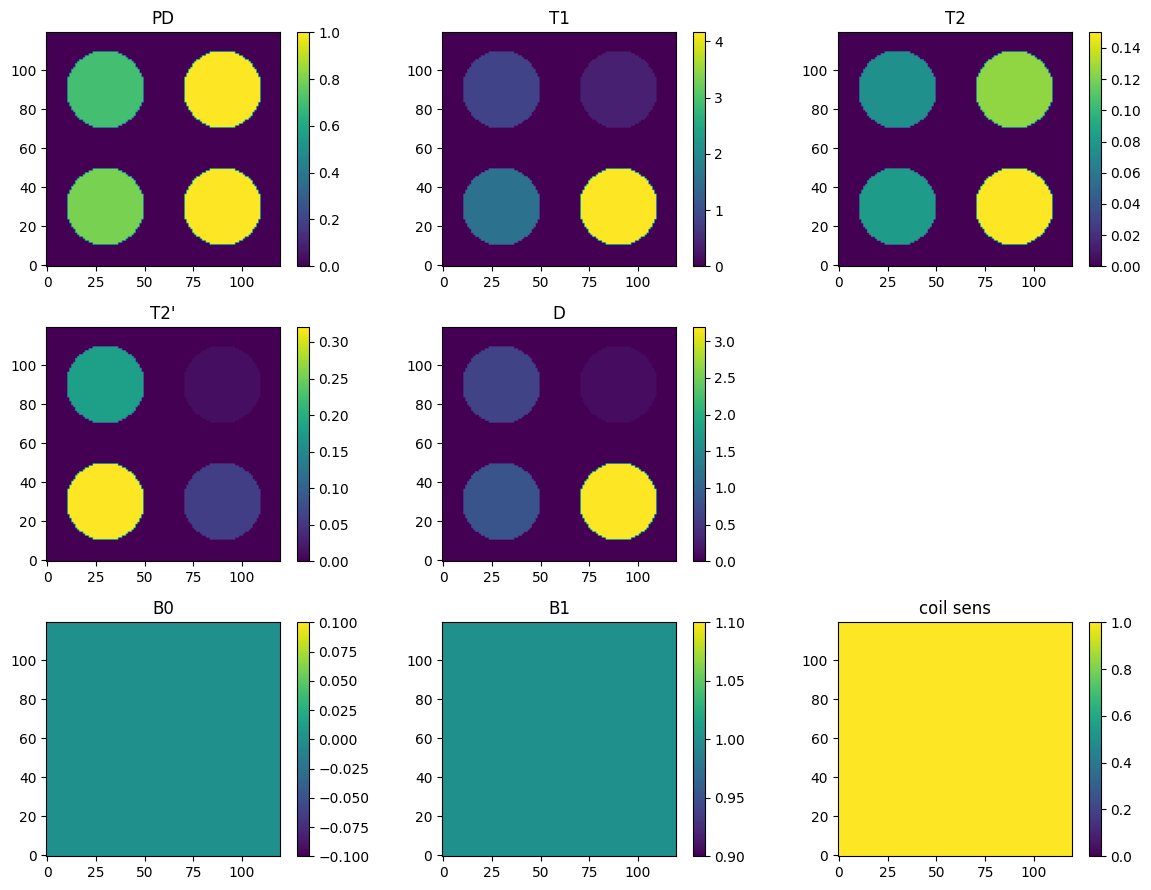

In [439]:
phantom_size = 120
phantom = mr0.util.load_phantom(size=(120,120))
phantom.PD = PD_map
phantom.T1 = T1_map
phantom.T2 = T2_map
phantom.T2dash = T2_dash_map
phantom.D = D_map
phantom.B0 = B0_map
phantom.B1 = B1_map
phantom.plot()

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.00145669 s
Compute Graph
Computing Graph: 0.0846669 s
Analyze Graph
Analyzing Graph: 0.000247404 s
Converting Rust -> Python: 0.00367642 s
<<<< Rust <<<<


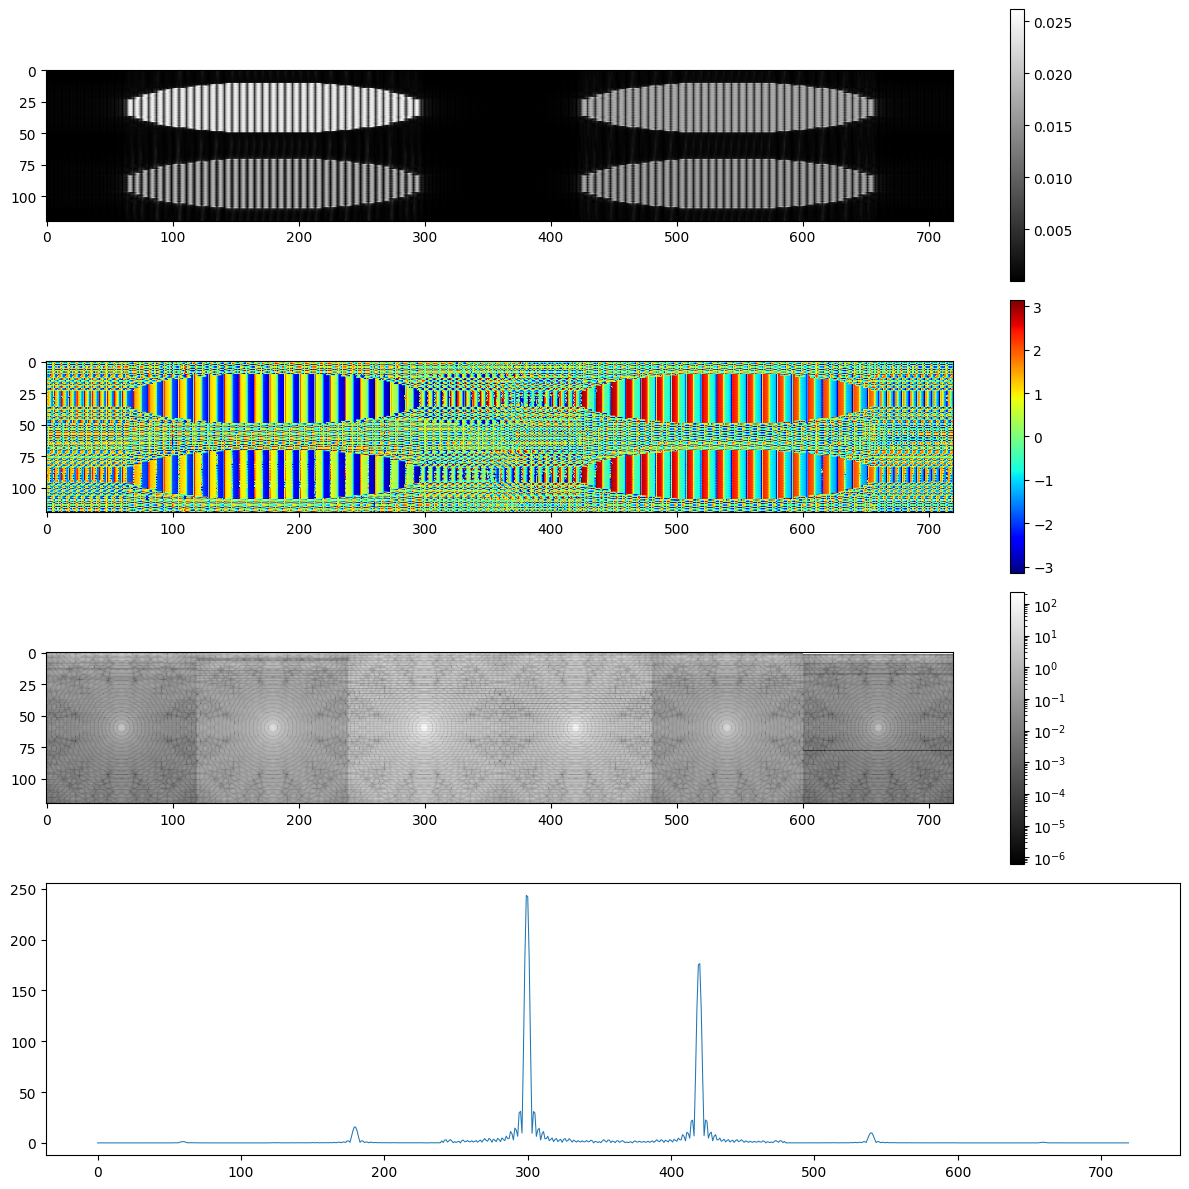

In [452]:
TR = 0.02
# seq_path = "seq/seq_p2n3.seq"
# delta_TE = 0.00735
seq_path = "seq/seq_p2n3_spoiler.seq"
delta_TE = 0.00243
seq = pp.Sequence()
seq.read(seq_path)
seq.calculate_kspace()
signal, ksp = mr0.util.simulate(seq, phantom, accuracy=1e-15)

k_space = signal.reshape(phantom_size, -1)
spectrum = torch.fft.ifftshift(k_space)
space = torch.fft.ifft2(spectrum)
space = torch.fft.fftshift(space)

plt.figure(figsize=(12, 12))
plt.subplot(4,1,1)
plt.imshow(np.abs(space.numpy()), cmap="gray")
plt.colorbar()

plt.subplot(4,1,2)
plt.imshow(np.angle(space.numpy()),cmap="jet")
plt.colorbar()

plt.subplot(4,1,3)
plt.imshow(np.abs(k_space.numpy()), cmap="gray", norm=LogNorm())
plt.colorbar()

plt.subplot(4,1,4)
plt.plot(np.abs(k_space.numpy())[k_space.shape[0]//2,:])

plt.tight_layout()

torch.Size([6, 120, 120])


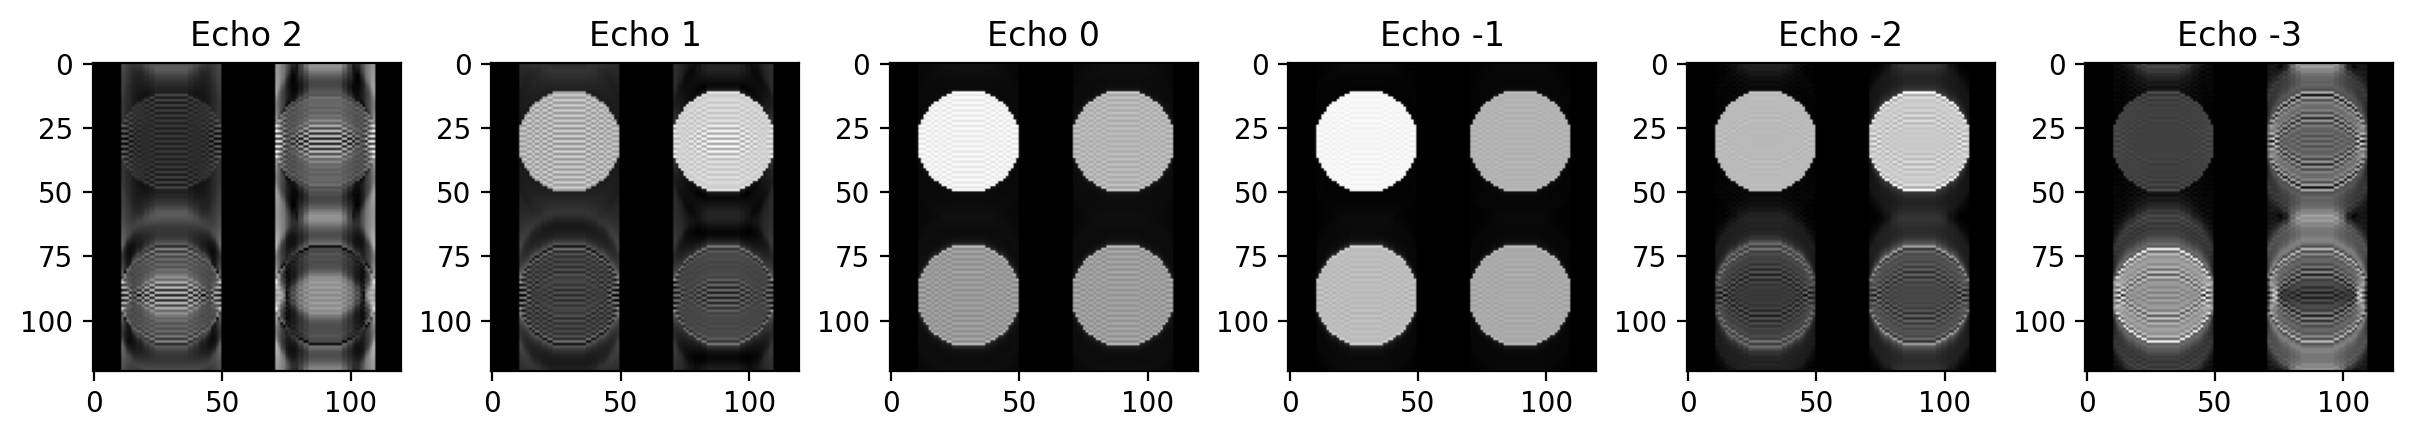

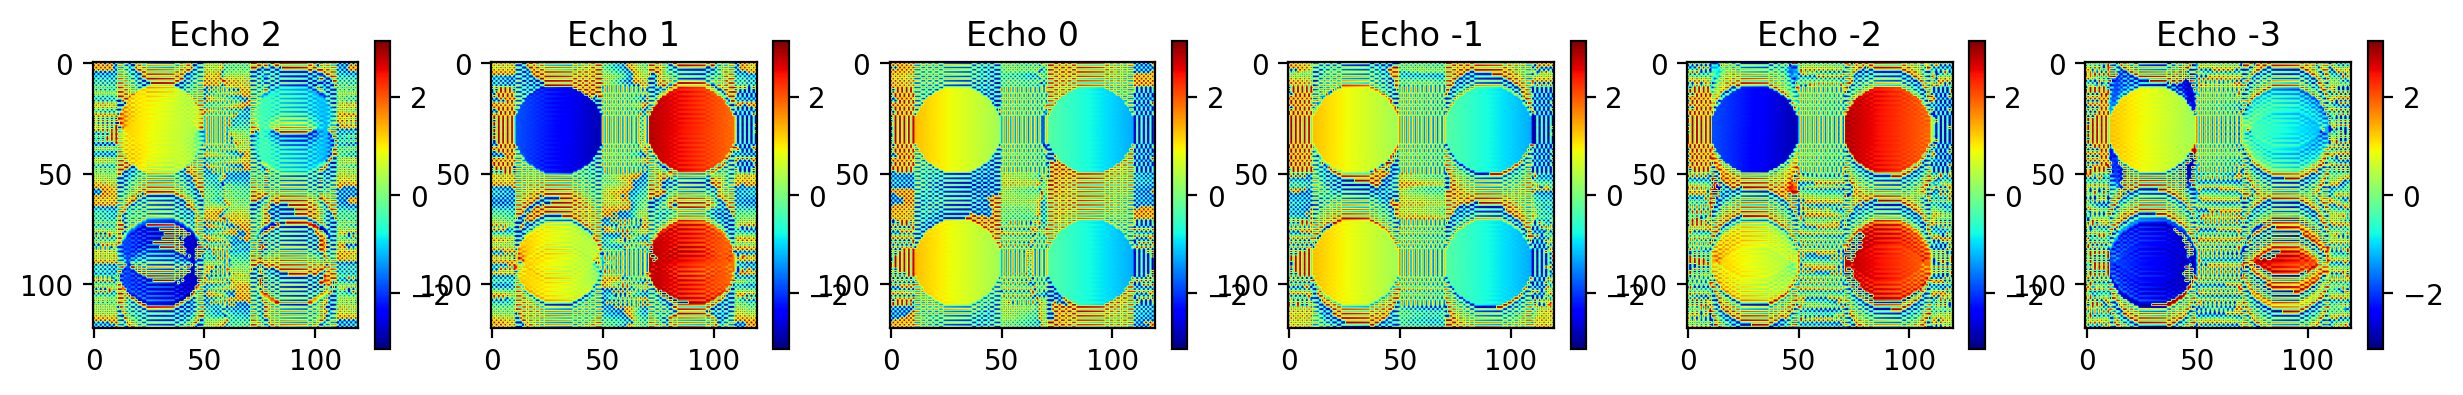

In [453]:
k_echoes = rearrange(k_space, "h (n w) -> n h w", n=6)
print(k_echoes.shape)

img_echoes = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.fftshift(k_echoes, dim=(1,2)), dim=(1,2)), dim=(1,2))

plt.figure(figsize=(15, 2), dpi=200)
for idx,i in enumerate(np.linspace(2, -3 , 6,dtype=int)):
    plt.subplot(1,6,idx+1)
    plt.imshow(np.abs(img_echoes[idx].numpy()), cmap="gray")
    plt.title(f"Echo {i}")
plt.show()
plt.figure(figsize=(15, 2), dpi=200)
for idx,i in enumerate(np.linspace(2, -3 , 6,dtype=int)):
    plt.subplot(1,6,idx+1)
    plt.imshow(np.angle(img_echoes[idx].numpy()), cmap="jet")
    plt.title(f"Echo {i}")
    plt.colorbar()
plt.show()

In [454]:
class LinearModel(nn.Module):
    def __init__(self, img):
        super(LinearModel, self).__init__()
        self.lambd = nn.Parameter(torch.rand(img.shape[0],img.shape[1],1))
        self.mu = nn.Parameter(torch.rand(img.shape[0],img.shape[1],1))
    def forward(self, n):
        return self.lambd*n+self.mu

print(([2,*img_echoes.shape]))
linear = nn.Linear(6, 1)
x = torch.zeros((2,1,6))
print(linear(x).shape)

def fit_T2(img, n):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    assert img.shape[0]==n.shape[0]
    img_plus = rearrange(img[torch.argwhere(n>=0).squeeze()],"n h w -> h w n").to(device)
    img_minus = rearrange(img[torch.argwhere(n<0).squeeze()],"n h w -> h w n").to(device)
    n_plus = n[torch.argwhere(n>=0).squeeze()].to(device)
    n_minus = n[torch.argwhere(n<0).squeeze()].to(device)

    linear_plus = LinearModel(img_plus).to(device)
    linear_minus = LinearModel(img_minus).to(device)
    optimizer_plus = torch.optim.Adam(linear_plus.parameters(), lr=1e-3)
    optimizer_minus = torch.optim.Adam(linear_minus.parameters(), lr=1e-3)
    n_epoch = 5000

    lossplus_list = []
    lossminus_list = []
    print(linear_plus(n_plus).shape, img_plus.shape)
    for epoch in tqdm(range(n_epoch)):
        optimizer_plus.zero_grad()
        optimizer_minus.zero_grad()
        loss_plus = torch.mean(torch.abs(linear_plus(n_plus)-torch.abs(img_plus)))
        loss_minus = torch.mean(torch.abs(linear_minus(n_minus)-torch.abs(img_minus)))
        loss_plus.backward()
        loss_minus.backward()
        optimizer_plus.step()
        optimizer_minus.step()
        lossplus_list.append(loss_plus.item())
        lossminus_list.append(loss_minus.item())

    print(linear_plus(n_plus).shape, linear_minus(n_minus).shape)

    print(img_plus.shape, img_minus.shape)
    print(n_plus, n_minus)

    return linear_plus, linear_minus
    


n = torch.linspace(2,-3,6)

# linear_plus,linear_minus = fit_T2(img_echoes,n)
linear_plus,linear_minus = fit_T2(img_echoes[1:-1],n[1:-1])

[2, 6, 120, 120]
torch.Size([2, 1, 1])
torch.Size([120, 120, 2]) torch.Size([120, 120, 2])


100%|██████████| 5000/5000 [00:06<00:00, 795.57it/s]

torch.Size([120, 120, 2]) torch.Size([120, 120, 2])
torch.Size([120, 120, 2]) torch.Size([120, 120, 2])
tensor([1., 0.], device='cuda:0') tensor([-1., -2.], device='cuda:0')


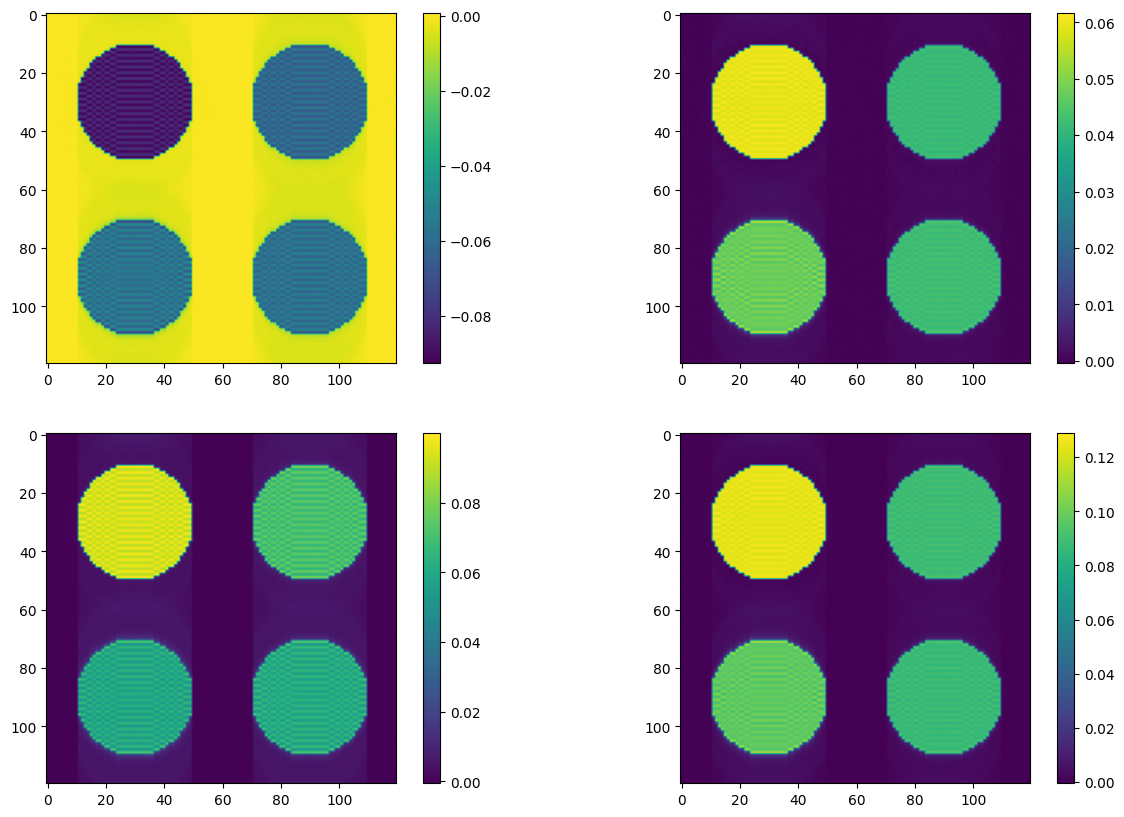

torch.Size([120, 120, 1])


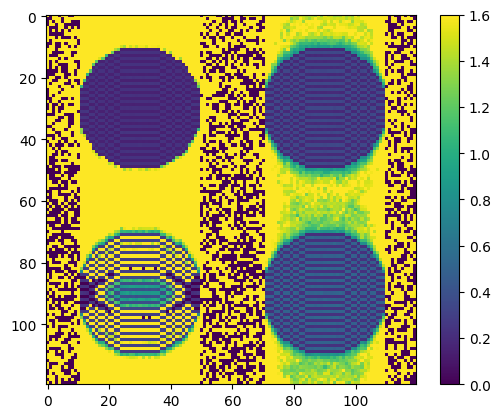

In [455]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.imshow((linear_plus.lambd.cpu().detach().numpy()))
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow((linear_minus.lambd.cpu().detach().numpy()))
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow((linear_plus.mu.cpu().detach().numpy()))
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow((linear_minus.mu.cpu().detach().numpy()))
plt.colorbar()
plt.show()
print((1/torch.abs(linear_plus.lambd.detach()+linear_minus.lambd.detach()).cpu()).shape)
T2_fit = (-2*delta_TE/(linear_plus.lambd.detach()+linear_minus.lambd.detach()).cpu())
plt.imshow((-2*delta_TE/(linear_plus.lambd.detach()+linear_minus.lambd.detach()).cpu()))
plt.clim(0,1.6)
plt.colorbar()
plt.show()

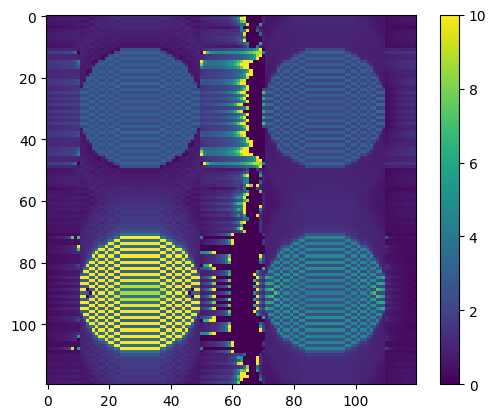

In [456]:
T2_fit = 1/torch.log(torch.abs(img_echoes[2]/img_echoes[3]))
plt.imshow(T2_fit)
plt.clim(0,10)
plt.colorbar()

In [445]:
T2_fit_1 = mask_1*T2_fit
T2_fit_2 = mask_2*T2_fit
T2_fit_3 = mask_3*T2_fit
T2_fit_4 = mask_4*T2_fit
print(T2_fit_1.nanmean(), T2_fit_2.nanmean(), T2_fit_3.nanmean(), T2_fit_4.nanmean())
print(T2_fit_1.nansum(), T2_fit_2.nansum(), T2_fit_3.nansum(), T2_fit_4.nansum())

tensor(2.5250, dtype=torch.float64) tensor(3.6441, dtype=torch.float64) tensor(2.5250, dtype=torch.float64) tensor(3.6441, dtype=torch.float64)
tensor(377233.2369, dtype=torch.float64) tensor(544421.7874, dtype=torch.float64) tensor(377233.2369, dtype=torch.float64) tensor(544421.7874, dtype=torch.float64)


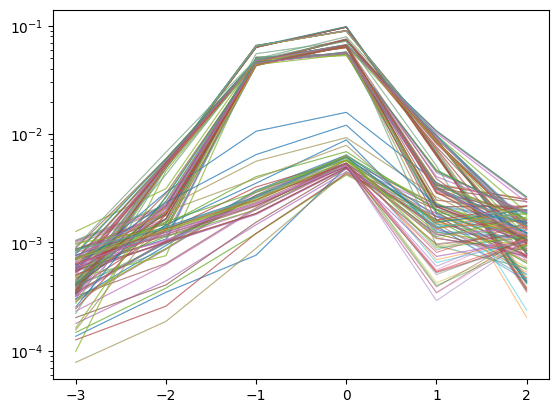

In [446]:
plt.plot(n,torch.abs(img_echoes[:,:,30]), alpha=0.5)
plt.plot(n,torch.abs(img_echoes[:,:,90]), alpha=0.5)
plt.yscale("log")
plt.show()

tensor([ 1.-1.7485e-07j, -1.+8.7423e-08j,  1.+0.0000e+00j,  1.+0.0000e+00j,
        -1.-8.7423e-08j,  1.-3.0199e-07j])


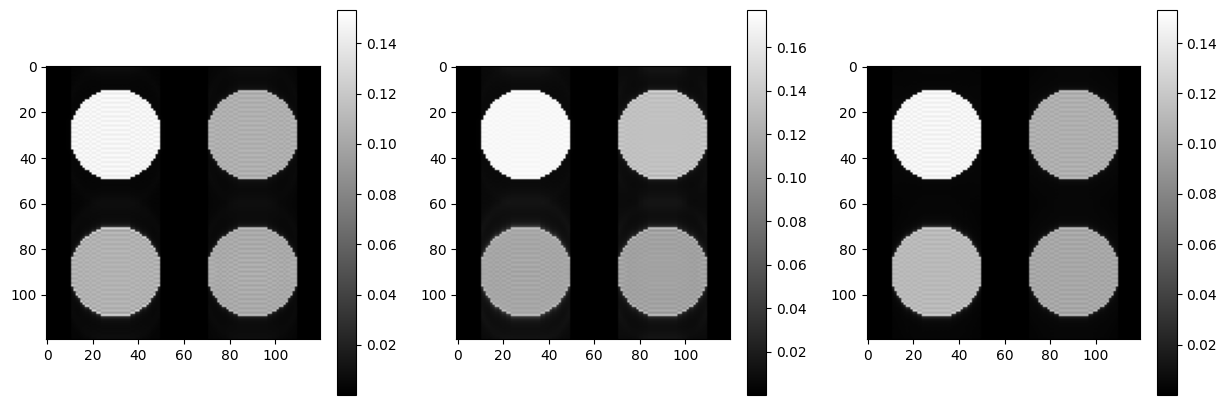

In [447]:
def u(n):
    return (n>=0).float()

phase = (u(n)-1)*torch.pi-torch.pi*n
print(torch.exp(1j*phase))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
# plt.imshow((torch.abs(img_echoes).sum(dim=0)).numpy(), cmap="gray")
plt.imshow(torch.abs((torch.abs(img_echoes)*torch.exp(1j*phase)[:,torch.newaxis,torch.newaxis]).sum(dim=0)).numpy(), cmap="gray")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow((torch.abs(img_echoes).sum(dim=0)).numpy(), cmap="gray")
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(torch.abs((img_echoes).sum(dim=0)).numpy(), cmap="gray")
plt.colorbar()